# RCD sockshop dataset

In [2]:
%reload_ext autoreload
%autoreload 2

In [7]:
from pathlib import Path

import pandas as pd
from scipy.stats import zscore

In [4]:
RCD_PATH = Path("../../rcd/")
RCD_DATA_PATH = RCD_PATH / "sock-shop-data"

<Axes: >

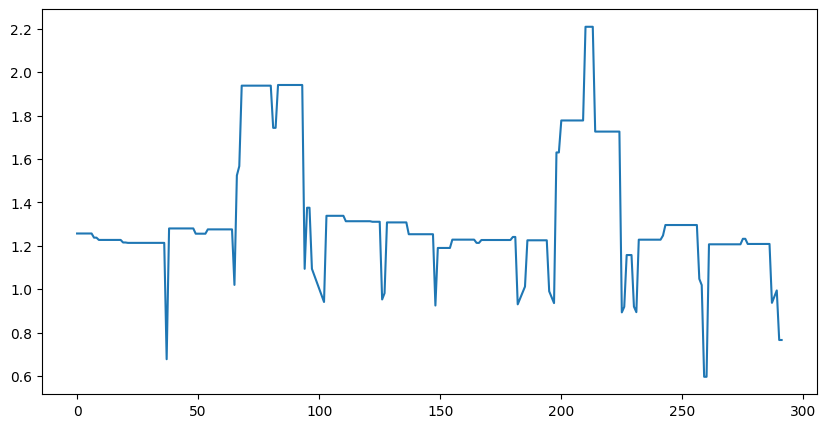

In [14]:
pd.read_csv(RCD_DATA_PATH / "carts-cpu" / "1" / "normal.csv").loc[:, "carts_cpu"].plot(figsize=(10, 5))
pd.read_csv(RCD_DATA_PATH / "user-mem" / "1" / "anomalous.csv").loc[:, "user_mem"].plot(figsize=(10, 3))

<Axes: >

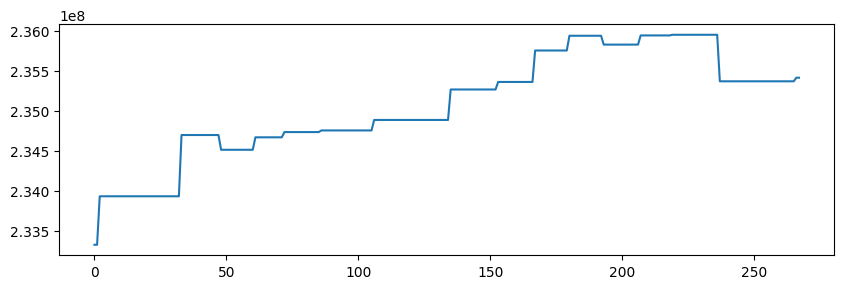